In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import json
import glob
import os
import re

from shared import *

In [3]:
base = "../exp/"
paths = glob.glob(base + "ubs_perf/2021-11-29T09:44:07+01:00.json")
data = [json.load(open(path)) for path in paths]

In [6]:
ubs_checks = pd.DataFrame.from_records([{
    **algo,
    'graph': path_to_graph(run['args'][1]),
    'metric': run['live_weight_file'],
    'epsilon': run['epsilon'],
} for run in data for algo in run['algo_runs']])

In [7]:
ubs_checks.query('rank > 9 & epsilon == 0.2').groupby(['algo', 'rank'])['running_time_ms'].describe()

count         mean          std         min          25%  \
algo          rank                                                              
dijkstra_tree 10    1282.0     0.715585     1.524016    0.013921     0.180961   
              11    1111.0     1.012990     1.866990    0.014235     0.328743   
              12    1055.0     1.685328     3.072251    0.043728     0.613919   
              13    1087.0     3.066400     3.569481    0.109105     1.202361   
              14    1220.0    13.131333    42.645392    0.060976     2.772835   
...                    ...          ...          ...         ...          ...   
sse_rphast    23    3016.0   394.256001   185.078557   72.200676   309.036324   
              24    4192.0   858.835118   480.806595  147.368999   547.687764   
              25    2118.0  1700.112547   742.224016  259.502660  1106.269879   
              26    1145.0  3145.375351  1103.481909  490.945600  2252.424318   
              27     656.0  5490.177398  2278.663716  774.493755  3890.613509   

                            50%          75%           max  
algo          rank                                          
dijkstra_tree 10       0.345510     1.133209     49.234099  
              11       0.556251     0.969789     25.458017  
              12       1.061950     1.795745     78.241829  
              13       2.114323     3.752382     45.833371  
              14       5.016029     9.335705    994.252246  
...                         ...          ...           ...  
sse_rphast    23     354.979005   454.196339   2074.781266  
              24     669.099590  1014.851794   2635.568518  
              25    1606.935238  2243.045937   4232.506397  
              26    3032.976006  3985.692641   7133.366955  
              27    5554.305788  7682.607184  12602.239413  

[72 rows x 8 columns]

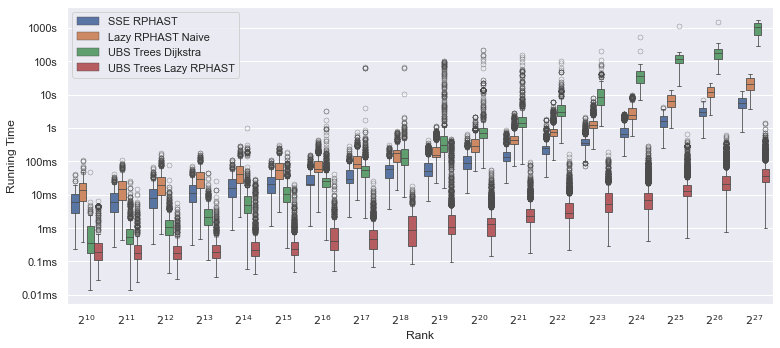

In [75]:
def pretty(val, pos):
    if val < 1.0:
        return f"{val}ms"
    elif val >= 1000:
        return f"{int(val/1000.0)}s"
    else: 
        return f"{int(val)}ms"
    
ubs_checks['rank_exp'] = ubs_checks['rank'].apply(lambda val: f"$2^{{{val}}}$")
plt.figure(figsize=(11,5))
g = sns.boxplot(data=ubs_checks.query('rank > 9 & epsilon == 0.2'), x='rank_exp', y='running_time_ms', hue='algo', 
                hue_order=['sse_rphast', 'lazy_rphast_naive', 'dijkstra_tree', 'lazy_rphast_tree'], 
                showmeans=False, linewidth=0.8, flierprops=dict(marker='o', markerfacecolor='none', markeredgewidth=0.3))
g.set_yscale('log')
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles, labels=['SSE RPHAST', 'Lazy RPHAST Naive', 'UBS Trees Dijkstra', 'UBS Trees Lazy RPHAST'])
g.set_ylabel('Running Time')
g.set_xlabel('Rank')
g.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10,numticks=10))
g.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(pretty))
plt.tight_layout()

In [9]:
ubs_checks['log_running_time_ms'] = np.log10(ubs_checks['running_time_ms'])

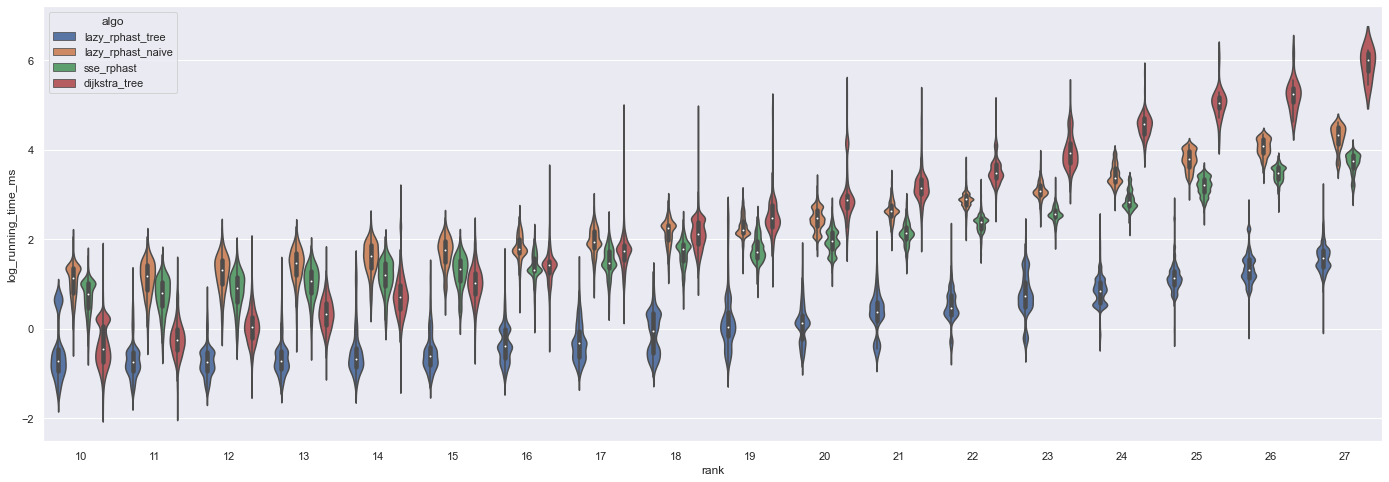

In [10]:
plt.figure(figsize=(24,8))
g = sns.violinplot(data=ubs_checks.query('rank > 9 & epsilon == 0.2'), x='rank', y='log_running_time_ms', hue='algo', scale='width')

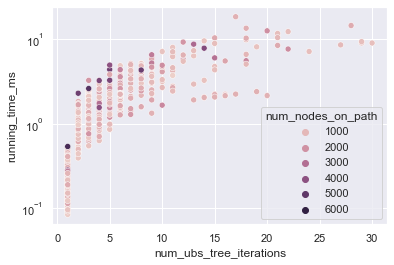

In [23]:
g = sns.scatterplot(data=ubs_checks.query('rank == 18 & epsilon == 0.2 & algo == "lazy_rphast_tree"'), x='num_ubs_tree_iterations', y='running_time_ms', hue='num_nodes_on_path')
g.set_yscale('log')

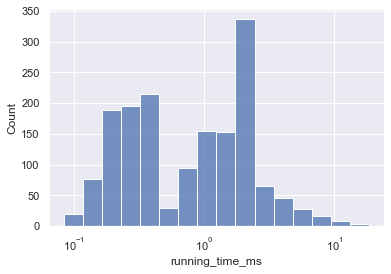

In [24]:
g = sns.histplot(data=ubs_checks.query('rank == 18 & epsilon == 0.2 & algo == "lazy_rphast_tree"'), x='running_time_ms', log_scale=True)

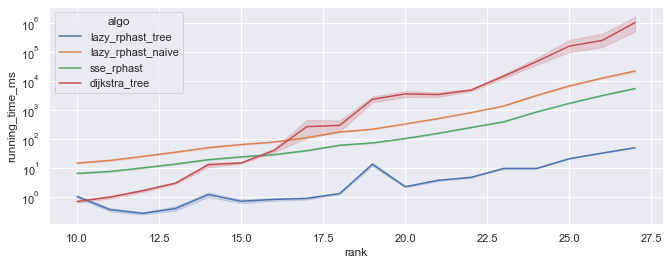

In [29]:
plt.figure(figsize=(11,4))
g = sns.lineplot(data=ubs_checks.query('rank > 9 & epsilon == 0.2'), x='rank', y='running_time_ms', hue='algo')
g.set_yscale('log')

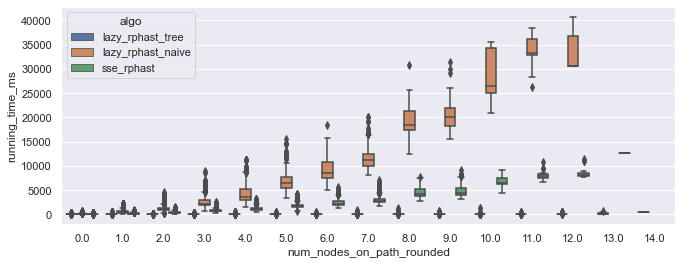

In [35]:
plt.figure(figsize=(11,4))
ubs_checks['num_nodes_on_path_rounded'] = (ubs_checks['num_nodes_on_path'] / 3000).round(0)
g = sns.boxplot(data=ubs_checks.query('rank > 9 & epsilon == 0.2 & algo != "dijkstra_tree"'), x='num_nodes_on_path_rounded', y='running_time_ms', hue='algo')
# g.set_yscale('log')

In [15]:
ubs_checks.query('rank > 9 & epsilon == 0.2').groupby(['algo', 'rank'])['running_time_ms'].describe().loc['dijkstra_tree']

,count,mean,std,min,25%,50%,75%,max
rank,,,,,,,,
10,1282.0,7.155849e-01,1.524016,0.013921,0.180961,3.455100e-01,1.133209e+00,4.923410e+01
11,1111.0,1.012990e+00,1.866990,0.014235,0.328743,5.562510e-01,9.697890e-01,2.545802e+01
12,1055.0,1.685328e+00,3.072251,0.043728,0.613919,1.061950e+00,1.795745e+00,7.824183e+01
13,1087.0,3.066400e+00,3.569481,0.109105,1.202361,2.114323e+00,3.752382e+00,4.583337e+01
14,1220.0,1.313133e+01,42.645392,0.060976,2.772835,5.016029e+00,9.335705e+00,9.942522e+02
15,1188.0,1.519648e+01,17.588967,0.254971,5.899317,1.028852e+01,1.750822e+01,1.968590e+02
16,1730.0,4.073738e+01,134.286560,0.447397,17.143621,2.639718e+01,3.262497e+01,3.201655e+03
17,1595.0,2.687889e+02,3557.930065,1.961225,33.506263,5.542475e+01,7.259994e+01,6.872105e+04
18,1628.0,2.965079e+02,2764.528304,8.321440,76.498928,1.277684e+02,2.421104e+02,6.591285e+04
